# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Для проведения исследования необходимо:
   - Изучить общую информацию о датафрейме
   - Обработать пропущенные и аномальные значения
   - Проверить и исправить дубликаты
   - Добавить новые колонки с недостающими значениями
   - Изучить основные параметры объектов
   - Изучить зависимость стоимости от характеристик

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

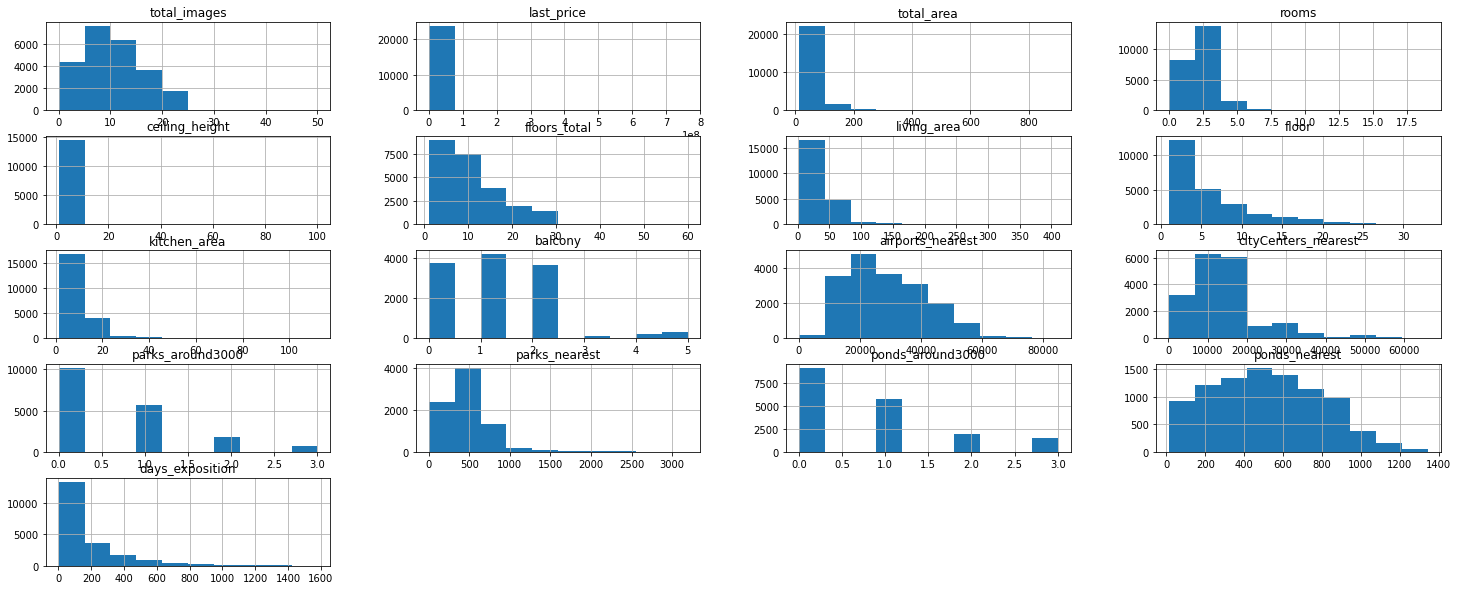

In [3]:
data.hist(figsize=(25, 10));

**Вывод**

   Столбец `first_day_exposition` переведем в формат даты, для более удобной работы.
   Столбцы `floors_total`, `rooms`, `floor`, `balcony` и `days_exposition` переведем в целочисленный формат.
   Столбец `locality_name` переведем с строку.
   Указано, что столбец `is_apartment` должен содержать булевы значения, здесь у него тип object, соответственно приведем в bool
    

### Предобработка данных

In [4]:
#пропуски по столбцам
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### Работа с пропусками и дубликатами

In [7]:
data.duplicated().sum()
#явных дубликатов нет

0

In [8]:
#неявные дубликаты в столбце с локациями
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].fillna('unknown')
data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок городского типа')
data['locality_name'] = data['locality_name'].str.replace('железнодорожной станции', 'станции')

In [9]:
# check
data.locality_name.nunique()

324

In [10]:
#чек
data.duplicated(subset=['total_area', 'floor', 'floors_total', 'cityCenters_nearest']).sum()

1549

In [11]:
#заполнила пропуски в столбце с высотой потолков медианным значением
data['ceiling_height'].isna().sum()
data['ceiling_height'] = data['ceiling_height'].fillna('2.65').astype(float)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

In [13]:
#заполнили пропуски в балконах нулевым значением, а в столбце с апартаментами False
data['balcony'] = data['balcony'].fillna(0).astype(int)
data['is_apartment'] = data['is_apartment'].fillna(False)

In [14]:
data['locality_name'] = data['locality_name'].astype(str)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

In [15]:
data['last_price'] = data['last_price'].astype(int)
data['floors_total'] = data['floors_total'].dropna().astype(int)

#### Аномалии

In [16]:
#дропнули аномальные значения в столбцах через срез
data = data.query('~floors_total.isna()')
data = data.query('rooms<10')
data = data.query('20<=total_area<=250')

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23471 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23471 non-null  int64         
 1   last_price            23471 non-null  int64         
 2   total_area            23471 non-null  float64       
 3   first_day_exposition  23471 non-null  datetime64[ns]
 4   rooms                 23471 non-null  int64         
 5   ceiling_height        23471 non-null  float64       
 6   floors_total          23471 non-null  float64       
 7   living_area           21628 non-null  float64       
 8   floor                 23471 non-null  int64         
 9   is_apartment          23471 non-null  bool          
 10  studio                23471 non-null  bool          
 11  open_plan             23471 non-null  bool          
 12  kitchen_area          21280 non-null  float64       
 13  balcony         

**Вывод**

Мы заполнили основные пропуски, которые возможно заполнить, и удалили неявные дубликаты в столбце с локацией.
Пропуски в столбцах с потолком, заполнили медианным значением. Нулевые и аномальные значения были удалены из таблицы.

In [19]:
data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price',
      'living_area', 'kitchen_area',
      'floor', 'floors_total']].apply(['count', 'min', 'max', 'median']).style.format("{:,.2f}")

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,471.00","23,471.00","23,471.00","20,323.00","23,471.00","21,628.00","21,280.00","23,471.00","23,471.00"
min,0.00,20.00,1.00,1.00,"12,190.00",2.00,1.30,1.00,1.00
max,9.00,250.00,100.00,"1,580.00","330,000,000.00",220.00,107.00,33.00,60.00
median,2.00,52.00,2.65,95.00,"4,600,000.00",30.00,9.10,4.00,9.00


In [26]:
data[data['last_price']>20000000].count()
data[data['last_price']<1000000].count()

total_images            223
last_price              223
total_area              223
first_day_exposition    223
rooms                   223
ceiling_height          223
floors_total            223
living_area             180
floor                   223
is_apartment            223
studio                  223
open_plan               223
kitchen_area            177
balcony                 223
locality_name           223
airports_nearest          1
cityCenters_nearest       1
parks_around3000          1
parks_nearest             1
ponds_around3000          1
ponds_nearest             0
days_exposition         178
dtype: int64

In [27]:
data = data.query('1000000<last_price<20000000')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22614 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22614 non-null  int64         
 1   last_price            22614 non-null  int64         
 2   total_area            22614 non-null  float64       
 3   first_day_exposition  22614 non-null  datetime64[ns]
 4   rooms                 22614 non-null  int64         
 5   ceiling_height        22614 non-null  float64       
 6   floors_total          22614 non-null  float64       
 7   living_area           20894 non-null  float64       
 8   floor                 22614 non-null  int64         
 9   is_apartment          22614 non-null  bool          
 10  studio                22614 non-null  bool          
 11  open_plan             22614 non-null  bool          
 12  kitchen_area          20535 non-null  float64       
 13  balcony         

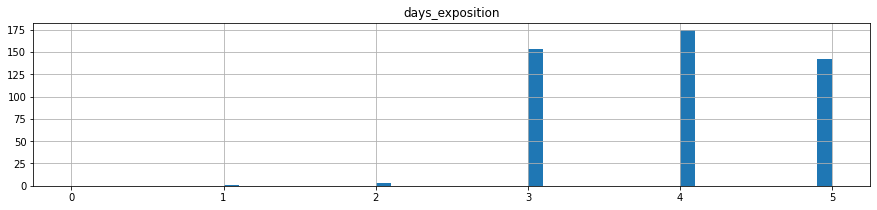

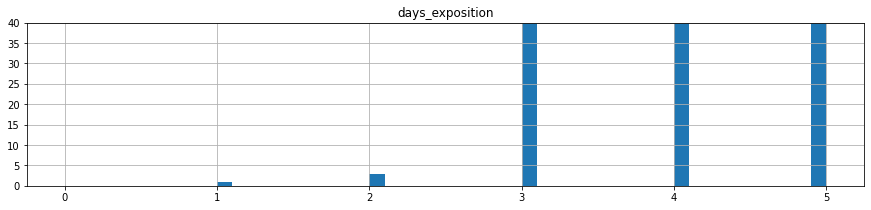

In [30]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

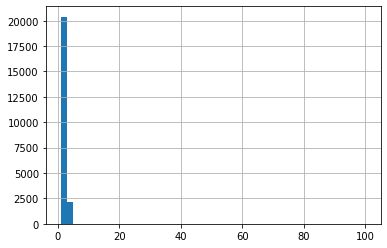

In [31]:
data.ceiling_height.hist(bins=50);

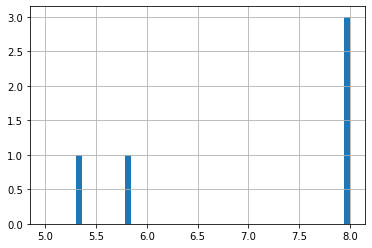

In [32]:
data.ceiling_height.hist(bins=50, range=(5, 8));

1.0

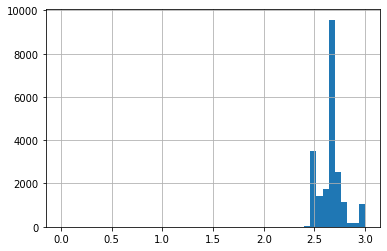

In [33]:
data.ceiling_height.hist(bins=50, range=(0, 3));
data.ceiling_height.min()

Потолки ближе к 6 метрам еще кажутся нормальными, но потолки в 8 метров выглядят аномалией. То же самое и с потолками меньше 2 метров. Количество таких значений не такое большое, поэтому оставим только значения больше двух и меньше восьми.

In [34]:
data = data.query('2<ceiling_height<4')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22514 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22514 non-null  int64         
 1   last_price            22514 non-null  int64         
 2   total_area            22514 non-null  float64       
 3   first_day_exposition  22514 non-null  datetime64[ns]
 4   rooms                 22514 non-null  int64         
 5   ceiling_height        22514 non-null  float64       
 6   floors_total          22514 non-null  float64       
 7   living_area           20801 non-null  float64       
 8   floor                 22514 non-null  int64         
 9   is_apartment          22514 non-null  bool          
 10  studio                22514 non-null  bool          
 11  open_plan             22514 non-null  bool          
 12  kitchen_area          20449 non-null  float64       
 13  balcony         

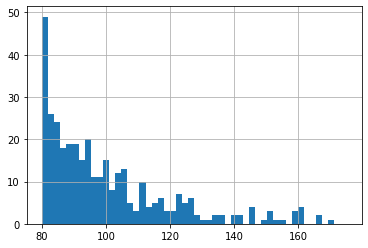

In [35]:
#data.living_area.hist(bins=50);

data.living_area.hist(bins=50, range=(80, 175));

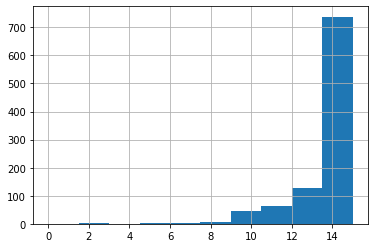

In [36]:
data.living_area.hist(range=(0, 15));

In [37]:
data.living_area.describe()

count    20801.000000
mean        32.530208
std         16.495991
min          2.000000
25%         18.500000
50%         30.000000
75%         41.400000
max        176.600000
Name: living_area, dtype: float64

In [38]:
# функция для заполнения пропусков в столбце с жилой площадью исходя из количества комнат(жилая площадь напрямую зависит 
# от количества комнат)
for a in data['rooms'].unique():
    data.loc[(data['rooms'] == a)&(data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == a), 'living_area'].mean()
    
data['living_area'].isna().sum()

1

Оставим только строки, где жилая площадь меньше десяти квадратов и больше 100

In [39]:
data = data.query('10<=living_area<=100')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22361 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22361 non-null  int64         
 1   last_price            22361 non-null  int64         
 2   total_area            22361 non-null  float64       
 3   first_day_exposition  22361 non-null  datetime64[ns]
 4   rooms                 22361 non-null  int64         
 5   ceiling_height        22361 non-null  float64       
 6   floors_total          22361 non-null  float64       
 7   living_area           22361 non-null  float64       
 8   floor                 22361 non-null  int64         
 9   is_apartment          22361 non-null  bool          
 10  studio                22361 non-null  bool          
 11  open_plan             22361 non-null  bool          
 12  kitchen_area          20309 non-null  float64       
 13  balcony         

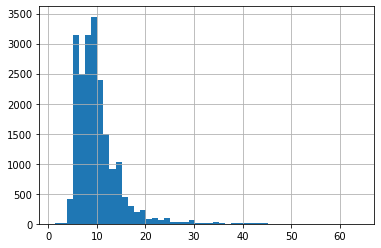

In [40]:
data.kitchen_area.hist(bins=50);

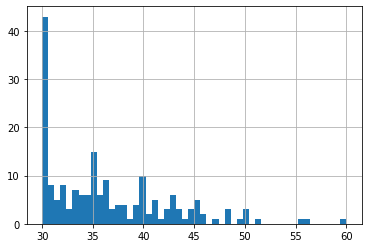

In [41]:
data.kitchen_area.hist(bins=50, range=(30, 60));

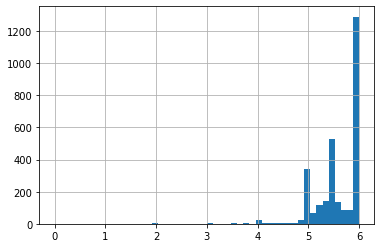

In [42]:
data.kitchen_area.hist(bins=50, range=(0, 6));

In [43]:
data.kitchen_area.describe()

count    20309.000000
mean        10.070867
std          4.605177
min          1.300000
25%          7.000000
50%          9.000000
75%         11.500000
max         64.000000
Name: kitchen_area, dtype: float64

In [44]:
#функция для заполнения пропусков в столбце с площадью кухни через общую площадь
for a in data['total_area'].unique():
    data.loc[(data['total_area'] == a)&(data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['total_area'] == a), 'kitchen_area'].mean()

In [45]:
data = data.query('5<=kitchen_area<45')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22070 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22070 non-null  int64         
 1   last_price            22070 non-null  int64         
 2   total_area            22070 non-null  float64       
 3   first_day_exposition  22070 non-null  datetime64[ns]
 4   rooms                 22070 non-null  int64         
 5   ceiling_height        22070 non-null  float64       
 6   floors_total          22070 non-null  float64       
 7   living_area           22070 non-null  float64       
 8   floor                 22070 non-null  int64         
 9   is_apartment          22070 non-null  bool          
 10  studio                22070 non-null  bool          
 11  open_plan             22070 non-null  bool          
 12  kitchen_area          22070 non-null  float64       
 13  balcony         

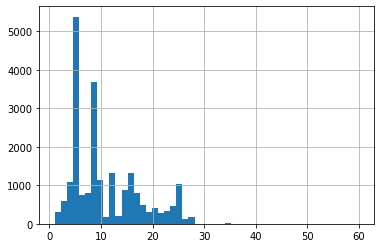

In [46]:
data.floors_total.hist(bins=50);

In [47]:
data.floors_total.value_counts()

5.0     5381
9.0     3681
16.0    1321
12.0    1312
10.0    1128
4.0     1082
25.0    1036
17.0     803
6.0      760
3.0      595
14.0     535
7.0      496
18.0     478
24.0     451
23.0     339
15.0     339
19.0     313
8.0      302
2.0      289
22.0     275
20.0     257
13.0     215
11.0     186
27.0     160
21.0     147
26.0     121
35.0      23
28.0      21
1.0       17
36.0       2
34.0       1
33.0       1
60.0       1
29.0       1
52.0       1
Name: floors_total, dtype: int64

In [48]:
data.floors_total.describe()

count    22070.000000
mean        10.824875
std          6.607817
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Отбросим значения до 30 и одноэтажные дома(больше похожи на частный сектор, скорее всего это не квартиры)

In [49]:
data = data.query('1<floors_total<=30')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22024 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22024 non-null  int64         
 1   last_price            22024 non-null  int64         
 2   total_area            22024 non-null  float64       
 3   first_day_exposition  22024 non-null  datetime64[ns]
 4   rooms                 22024 non-null  int64         
 5   ceiling_height        22024 non-null  float64       
 6   floors_total          22024 non-null  float64       
 7   living_area           22024 non-null  float64       
 8   floor                 22024 non-null  int64         
 9   is_apartment          22024 non-null  bool          
 10  studio                22024 non-null  bool          
 11  open_plan             22024 non-null  bool          
 12  kitchen_area          22024 non-null  float64       
 13  balcony         

### Посчитайте и добавьте в таблицу новые столбцы

In [51]:
#цена квадратного метра
data['price_per_meter'] = data['last_price']/data['total_area']

#день недели публикации объявления
data['day_exposition'] = data['first_day_exposition'].dt.weekday

#месяц публикации объявления
data['month_exposition'] = data['first_day_exposition'].dt.month

#год публикации объявления
data['year_exposition'] = data['first_day_exposition'].dt.year


data['city_center_km'] = data['cityCenters_nearest']//1000
data['city_center_km'] = data['city_center_km'].fillna(99).astype(int) #заполнили 99 чтобы в последствии отсеять

In [52]:
#тип этажа квартиры
def floor_type(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif floor<0:
        return 'аномалия'
    return 'другой'
    
data['floor_category'] = data.apply(floor_type, axis=1)

In [53]:
data['floor_category'].unique()

array(['другой', 'первый', 'последний'], dtype=object)

Аномальных значений по этажам нет

In [54]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_exposition,month_exposition,year_exposition,city_center_km,floor_category
0,20,13000000,108.00,2019-03-07,3,2.70,16.0,51.000000,8,False,...,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,16,другой
1,7,3350000,40.40,2018-12-04,1,2.65,11.0,18.600000,1,False,...,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,18,первый
2,10,5196000,56.00,2015-08-20,2,2.65,5.0,34.300000,4,False,...,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,13,другой
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.000000,13,False,...,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,8,другой
5,10,2890000,30.40,2018-09-10,1,2.65,12.0,14.400000,5,False,...,NaN,NaN,NaN,55.0,95065.789474,0,9,2018,99,другой
6,6,3700000,37.30,2017-11-02,1,2.65,26.0,10.600000,6,False,...,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,19,другой
7,5,7915000,71.60,2019-04-18,2,2.65,24.0,31.607043,22,False,...,NaN,0.0,NaN,NaN,110544.692737,3,4,2019,11,другой
8,20,2900000,33.16,2018-05-23,1,2.65,27.0,15.430000,26,False,...,NaN,NaN,NaN,189.0,87454.764777,2,5,2018,99,другой
9,18,5400000,61.00,2017-02-26,3,2.50,9.0,43.600000,7,False,...,NaN,0.0,NaN,289.0,88524.590164,6,2,2017,15,другой
10,5,5050000,39.60,2017-11-16,1,2.67,12.0,20.300000,3,False,...,310.0,2.0,553.0,137.0,127525.252525,3,11,2017,13,другой


### Проведите исследовательский анализ данных

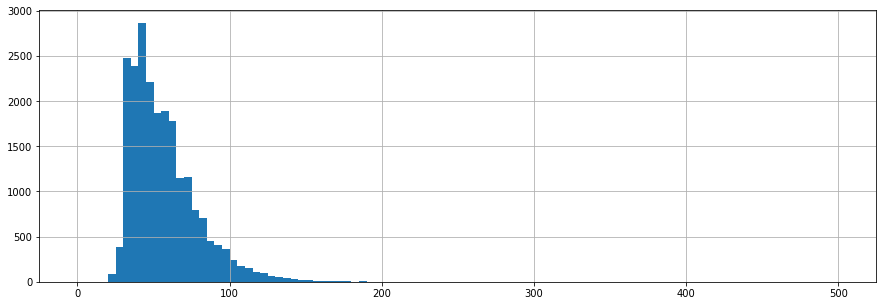

In [55]:
#общая площадь
data['total_area'].hist(bins=100, range=(0, 500), figsize=(15, 5));

Больше всего квартир продается площадью 40-50 квадратных метров, что в целом логично, это средняя площадь квартир с 1-2 комнатами.

<AxesSubplot:>

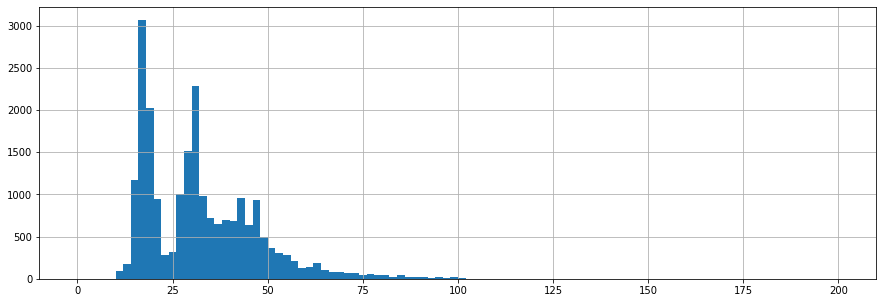

In [56]:
#жилая площадь
data['living_area'].hist(bins=100, range=(0, 200), figsize=(15, 5))

На графике видно два отчетливых пика с жилой площадью в районе 18 квадратов и 30 квадратов. Причина может быть в разном количестве комнат, чем больше комнат, тем больше жилая площадь.

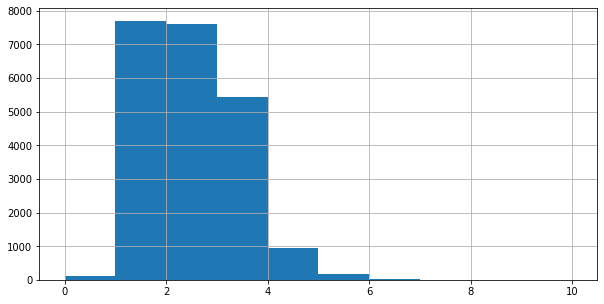

In [57]:
#количество комнат
data['rooms'].hist(bins = 10, range = (0, 10), figsize=(10, 5));

График в целом подтверждает предыдущие гипотезы по площади и жилой площади, больше всего квартир с 1-2 комнатами.

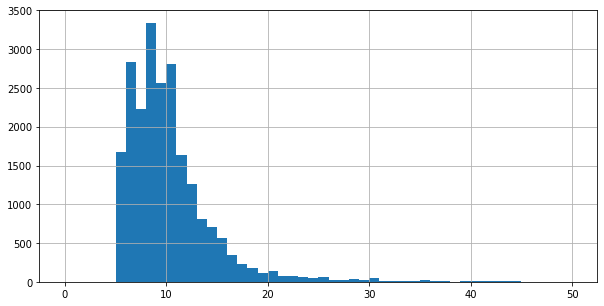

In [58]:
#площадь кухни
data['kitchen_area'].hist(range = (0, 50), bins=50, figsize=(10, 5));

Средняя площадь кухни по России варьируется от 6 до 20 метров, что мы в целом и видим на графике, но самое частое значение 6-10м.

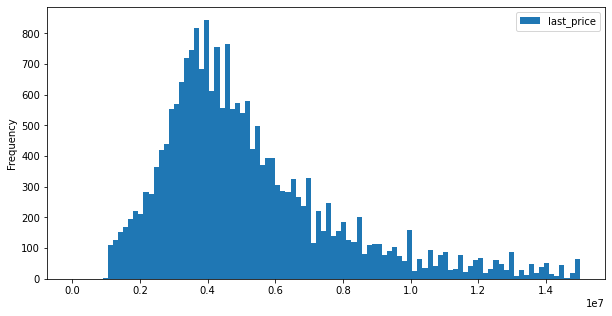

In [59]:
#цена
data.plot(y='last_price', kind='hist', bins=100, range=(0, 15000000), figsize=(10, 5));

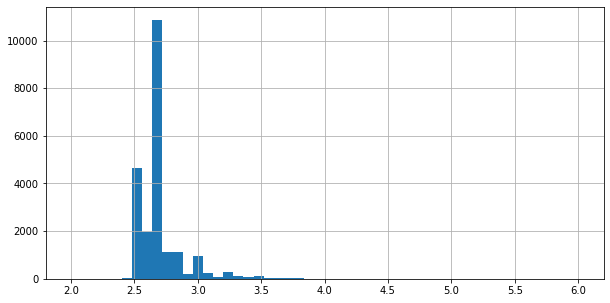

In [60]:
#высота потолков
data['ceiling_height'].hist(bins=50, figsize=(10, 5), range=(2, 6));

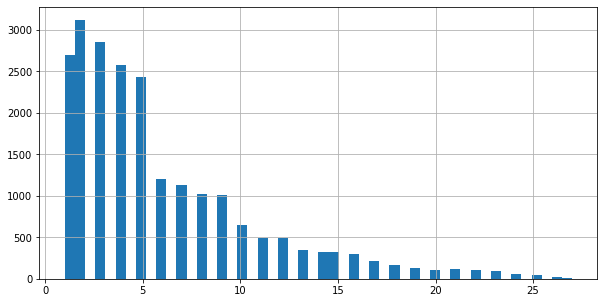

In [61]:
#этаж
data['floor'].hist(bins=50, figsize=(10, 5));

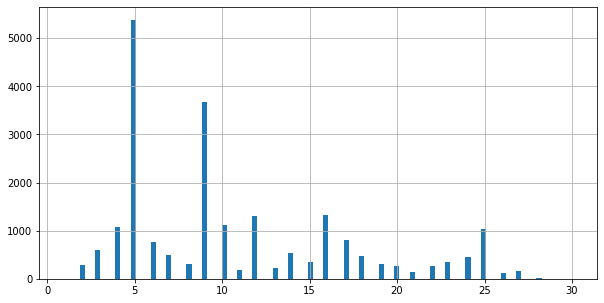

In [62]:
#всего этажей в доме
data['floors_total'].hist(bins=100, range=(1, 30), figsize=(10, 5));

Чаще всего втречаются 5-ти и 9-ти этажные здания.

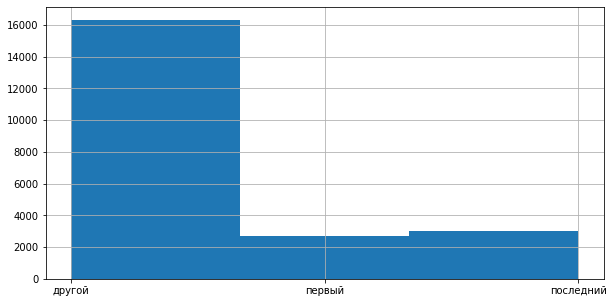

In [63]:
#категория этажа
data['floor_category'].hist(bins=3, figsize=(10, 5));

Больше всего квартир продаются в пределах 10 этажа.

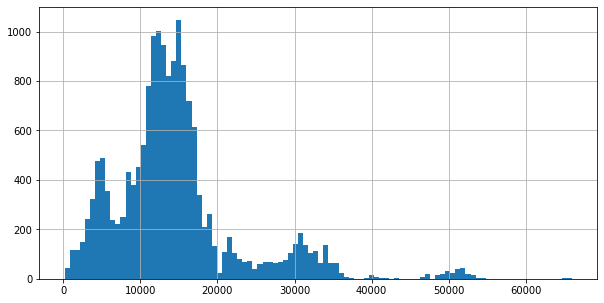

In [64]:
#удаленность от центра
data['cityCenters_nearest'].hist(bins=100, figsize=(10, 5));

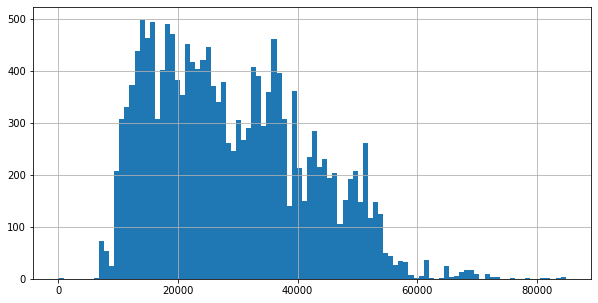

In [65]:
#расстояние до ближайшего аэропорта
data['airports_nearest'].hist(bins=100, figsize=(10, 5));

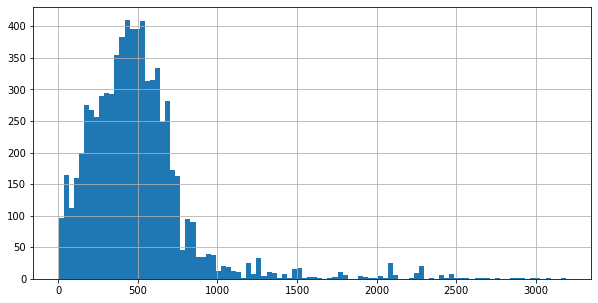

In [66]:
#расстояние до ближайшего парка
data['parks_nearest'].hist(bins=100, figsize=(10, 5));

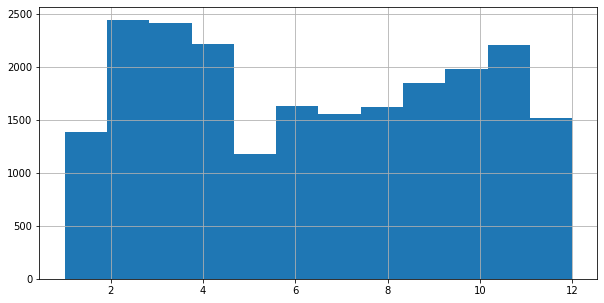

In [67]:
#месяц продажи квартиры
data['month_exposition'].hist(bins=12, figsize=(10, 5));

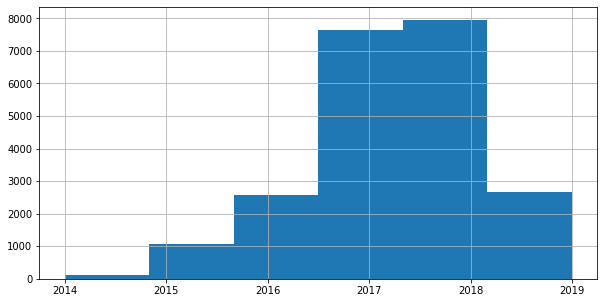

In [68]:
data['year_exposition'].hist(bins=6, figsize=(10, 5));

В конце и в начале года продажи падают, в мае резкий спад.

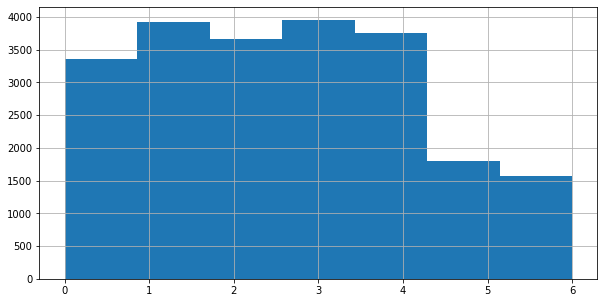

In [69]:
#день выкладки объявления
data['day_exposition'].hist(bins=7, figsize=(10,5));

В выходные объявлений выкладывают меньше всего.

#### Быстрые и медленные продажи

In [70]:
data['days_exposition'].describe()

count    19203.000000
mean       177.704109
std        216.208524
min          1.000000
25%         44.000000
50%         94.000000
75%        226.000000
max       1580.000000
Name: days_exposition, dtype: float64

На графике и в описании видим очень странные значения, слишком долгие продажи квартир. На сайте указано, что срок размещения *бесплантых* объявлений составляет 120 дней. Добавим к этому объявления платные, которые могут продержаться дольше, но в любом случае, продажа квартиры в 4,5 года выглядит очень странно. На сайте так же сказано, что объявления могут автоматически удаляться через 45 дней, это может объяснить значения первого квартиля.

<AxesSubplot:>

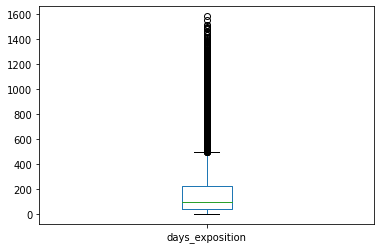

In [71]:
data['days_exposition'].plot(kind='box')
#коробчатая диаграмма показывает, что выбросы начинаются после значения 500. В целом значения выше 120 дней уже можно считать
#очень длинными, однако отбросим все строки до 500 дней.

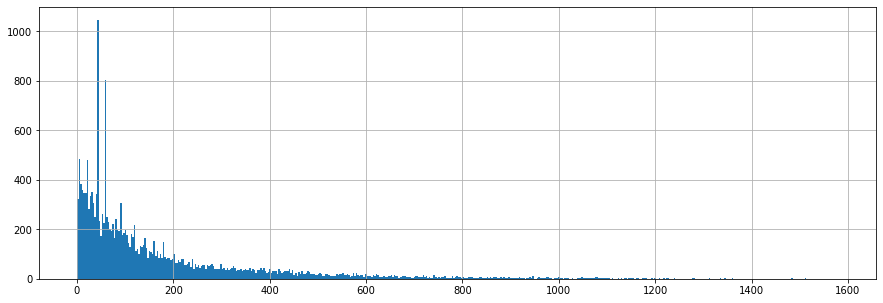

In [72]:
data['days_exposition'].hist(bins=500, figsize=(15, 5));

In [73]:
data['days_exposition'].quantile([0.0012, 0.25, .5, .99, .9988])

0.0012       3.0000
0.2500      44.0000
0.5000      94.0000
0.9900    1054.0000
0.9988    1360.9576
Name: days_exposition, dtype: float64

In [75]:
data['days_exposition'] = data['days_exposition'].fillna(19.5)
good_days_data = data.query('19.5<=days_exposition<=1200')
good_days_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19706 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          19706 non-null  int64         
 1   last_price            19706 non-null  int64         
 2   total_area            19706 non-null  float64       
 3   first_day_exposition  19706 non-null  datetime64[ns]
 4   rooms                 19706 non-null  int64         
 5   ceiling_height        19706 non-null  float64       
 6   floors_total          19706 non-null  float64       
 7   living_area           19706 non-null  float64       
 8   floor                 19706 non-null  int64         
 9   is_apartment          19706 non-null  bool          
 10  studio                19706 non-null  bool          
 11  open_plan             19706 non-null  bool          
 12  kitchen_area          19706 non-null  float64       
 13  balcony         

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Заполнила пропуски числом маркером (19,5, потому что половинчатых значений нет и его можно включить в срез). Приняла такое решение, поскольку в целом нам этот столбец в дальнейшем не понадобится, скорость продаж исследовалась до среза.
        
Я пробовала добавить условие фильтрации, чтобы пропуски оставались, но мне возвращались значения без пропусков в любом случае (пробовала и в query указывать, через loc). Я не знаю ответа.

На графика можно увидеть первый пик примерно в 20 дней. А первый квартиль на значении в 23 дня, поэтому значения до 20 дней будем считать аномальными. Следующий пик на 45 днях.
В этом столбце у нас видно аномально длинные продажи, вплоть до 4 лет. Это вполне можно считать выбросами, однако непонятно почему такие значения появились. Возможно некоторые объявления были не сняты с продажи самими пользователями, возможно это ошибка выгрузки данных (объявление не показывается, но и не считается удаленным), возможно они просто не удалялись автоматически.

In [77]:
#скорость продаж по годам
year_sells = good_days_data.pivot_table(index='year_exposition', values='days_exposition',
                                        aggfunc=['count', 'mean'])
year_sells

,count,mean
,days_exposition,days_exposition
year_exposition,,
2014,97,707.443299
2015,1011,575.856083
2016,2533,317.454599
2017,6907,167.887505
2018,6929,96.823423
2019,2229,26.424406


<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Я понимаю, что после заполнения пропусков странным значением данные могут быть не очень актуальны. Но, я проверила скорость продаж на сырых данных, на данных без пропусков, на срезе, везде сохраняется тенденция на увеличение скорости продаж квартиры. Можно предположить что выросло и количество пользователей, поскольку самих объявлений тоже становится больше.

#### Корреляция стоимости жилья с другими факторами

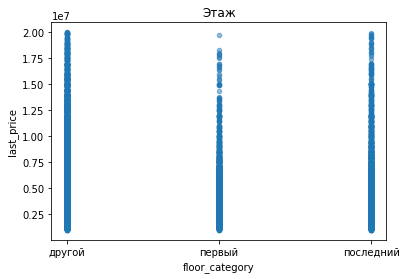

In [79]:
#зависимость от этажа
good_days_data.plot(x='floor_category', y='last_price', kind='scatter', alpha=0.5, title='Этаж');

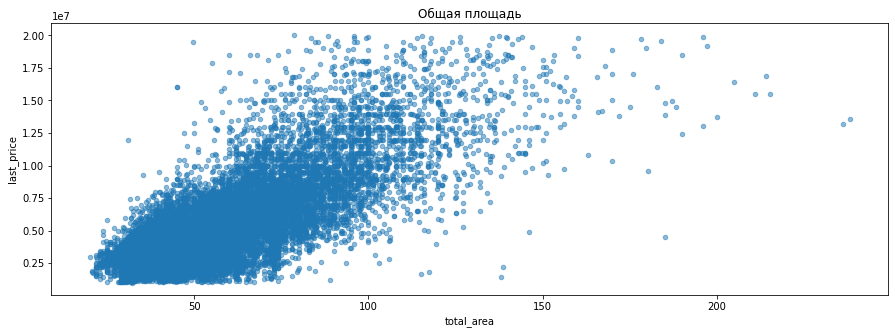

In [80]:
#зависимость от общей площади
good_days_data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.5, title='Общая площадь', figsize=(15, 5));

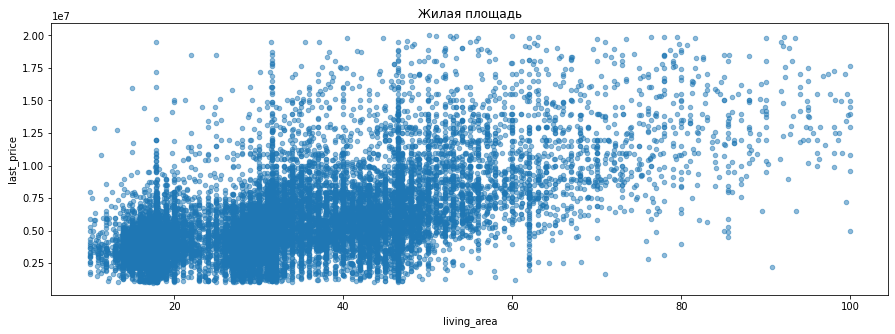

In [81]:
#зависимость от жилой площади
good_days_data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.5, title='Жилая площадь', figsize=(15, 5));

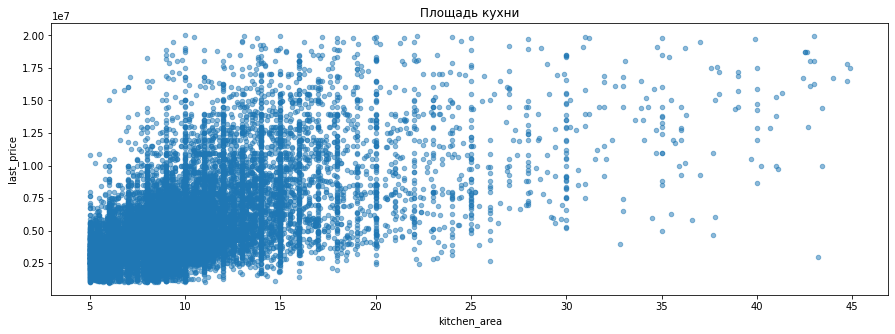

In [82]:
#зависимость от площади кухни
good_days_data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.5, title='Площадь кухни', figsize=(15, 5));

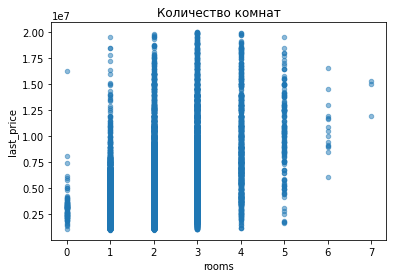

In [83]:
#зависимость от количества комнат
good_days_data.plot(x='rooms', y='last_price', kind='scatter', alpha=0.5, title='Количество комнат');

<AxesSubplot:xlabel='day_exposition'>

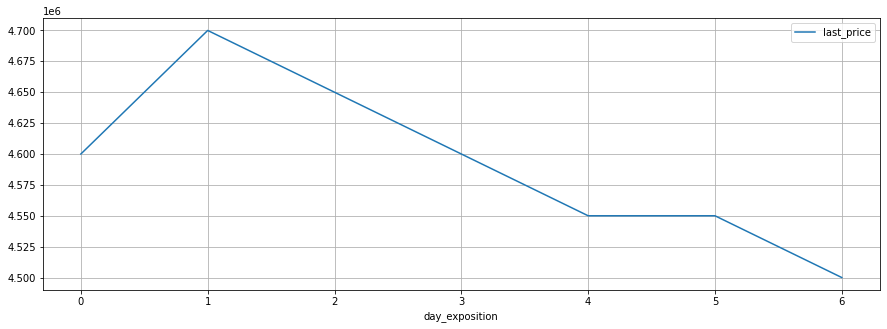

In [84]:
#зависимость от дня размещения
day_exposition_pivot = good_days_data.pivot_table(index = 'day_exposition', values='last_price',
                                                aggfunc=('median')).plot(figsize=(15,5), grid=True);
day_exposition_pivot

<AxesSubplot:xlabel='month_exposition'>

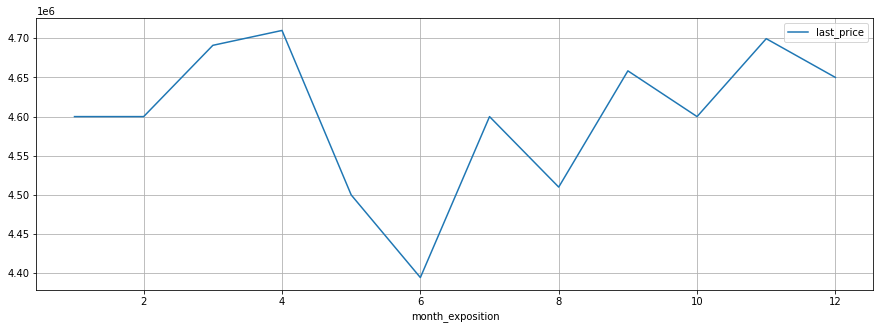

In [85]:
#зависимость от месяца размещения
month_exposition_pivot = good_days_data.pivot_table(index = 'month_exposition', values='last_price',
                                                aggfunc=('median')).plot(figsize=(15,5), grid=True);
month_exposition_pivot

<AxesSubplot:xlabel='year_exposition'>

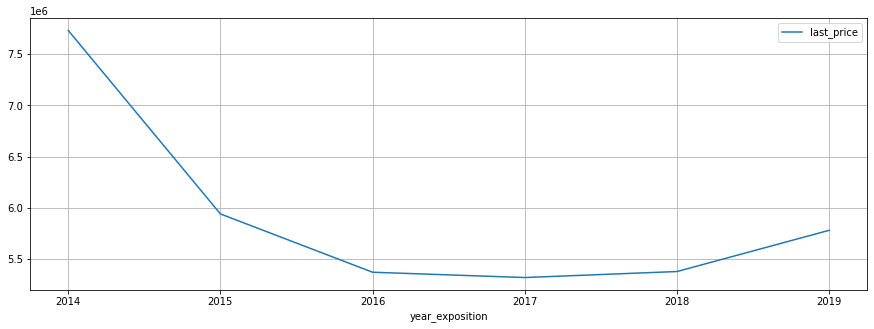

In [86]:
#зависимость от года размещения
year_exposition_pivot = good_days_data.pivot_table(index = 'year_exposition', values='last_price',
                                                aggfunc=('mean'))
year_exposition_pivot.plot(figsize=(15, 5), grid=True)

In [87]:
year_exposition = good_days_data.pivot_table(index='year_exposition', values=['last_price', 'total_area',
                                                                              'living_area'],
                                            aggfunc=('count', 'mean'));
year_exposition

last_price               living_area            total_area  \
                     count          mean       count       mean      count   
year_exposition                                                              
2014                  97.0  7.730703e+06          97  39.740654         97   
2015                1011.0  5.942711e+06        1011  35.284683       1011   
2016                2533.0  5.374604e+06        2533  33.126180       2533   
2017                6907.0  5.322932e+06        6907  32.212546       6907   
2018                6929.0  5.381493e+06        6929  31.853130       6929   
2019                2229.0  5.783161e+06        2229  32.504665       2229   

                            
                      mean  
year_exposition             
2014             71.727835  
2015             61.884382  
2016             57.515401  
2017             56.555539  
2018             55.817718  
2019             56.239000

**Вывод**

Больше всего стоимость жилья зависит от общей и жилой площадей, площади кухни и года. Этаж, на котором расположена квартира не влияет на стоимость.

Можно заметить, что до 2018 года увеличивается количество объявлений, медианная цена при этом снижается к 2016 году и поднимается снова в 2019. Так же можно заметить, что к 2017 году уменьшается площадь продаваемых квартир.

#### Средняя стоимость квадратного метра у локаций, с самым большим количеством объявлений

<AxesSubplot:ylabel='locality_name'>

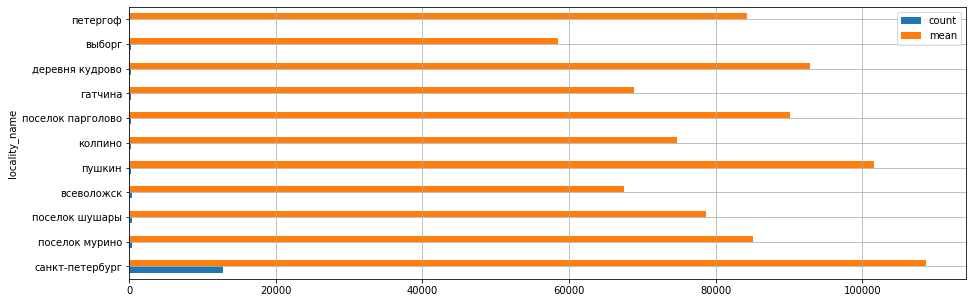

In [88]:
#средняя стоимость по самым частым объявлениям
locality_price = good_days_data.pivot_table(index='locality_name', values='price_per_meter',
                                            aggfunc=['count','mean'])
locality_price.columns = ['count', 'mean']
locality_price.sort_values('count', ascending=False).head(11).style.format("{:,.2f}")
locality_price.sort_values('count', ascending=False).head(11).plot(
    kind='barh', figsize=(15, 5), grid=True)
#больше всего объявлений из Санкт-Петербурга, самый дорогой тоже Питер, самый дешевый Выборг

#### Стоимость каждого километра в Санкт-Петербурге

<AxesSubplot:xlabel='city_center_km'>

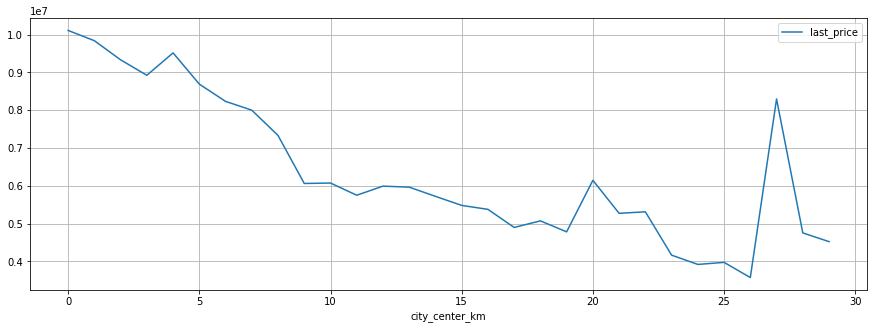

In [89]:
#посчитаем среднюю стоимость квадратного метра для каждого километра
data_saint_p = good_days_data.query('locality_name=="санкт-петербург" and city_center_km!=99')

mean_price = data_saint_p.pivot_table(index='city_center_km', values='last_price', aggfunc='mean')
mean_price.plot(figsize=(15, 5), grid=True)

In [90]:
data_saint_p.loc[data_saint_p['city_center_km']==27]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_exposition,month_exposition,year_exposition,city_center_km,floor_category
748,13,14350000,74.0,2017-11-28,2,3.13,5.0,30.0,3,False,...,1496.0,0.0,NaN,128.0,193918.918919,1,11,2017,27,другой
5961,6,2250000,32.0,2018-02-27,1,2.65,2.0,16.5,2,False,...,NaN,0.0,NaN,178.0,70312.500000,1,2,2018,27,последний


Можно заметить, что чем дальше помещение от центра, тем ниже становится стоимость, однако, скорее всего, не только удаленность от центра могла повлиять на стоимость.
На 27 километре есть выброс, в даннос объекте очень большая стоимость квадрата и общая стоимость квартиры.

In [91]:
data_saint_p.pivot_table(index='city_center_km', values=['total_area', 'living_area', 'rooms'], aggfunc='mean')

,living_area,rooms,total_area
city_center_km,,,
0,50.187892,3.000000,85.935238
1,48.267492,2.791411,79.828221
2,49.157160,2.774038,80.563894
3,47.341488,2.743210,79.283877
4,45.520385,2.652778,78.651219
5,40.652562,2.389892,71.512762
6,36.253563,2.111765,65.442353
7,37.074059,2.224615,64.445292
8,36.383791,2.144161,63.043084


***Наблюдение***

Просадка по цене может объясняться уменьшением площади квартиры и ее жилой площади, на 20 км из-за этого же может быть небольшой пик.

На 27 километре же пик из-за аномально высокой цены.

In [92]:
data_saint_p[data_saint_p['city_center_km']==3].sort_values(by='last_price', ascending=False).head(40)
data_saint_p[data_saint_p['last_price']>10000000].sort_values(by='last_price', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_exposition,month_exposition,year_exposition,city_center_km,floor_category
975,19,19999000,78.6,2018-09-19,3,2.96,6.0,50.2,4,False,...,592.0,0.0,NaN,180.0,254440.203562,2,9,2018,3,другой
22172,2,19990000,137.4,2018-11-28,3,2.65,19.0,52.6,17,False,...,NaN,0.0,NaN,68.0,145487.627365,2,11,2018,4,другой
6347,13,19980000,88.3,2018-08-31,3,2.80,24.0,53.4,5,False,...,NaN,0.0,NaN,140.0,226274.065685,4,8,2018,12,другой
2251,20,19950000,115.5,2017-04-14,3,2.75,20.0,60.0,9,False,...,288.0,3.0,311.0,256.0,172727.272727,4,4,2017,10,другой
21040,15,19950000,96.0,2017-08-11,3,2.90,7.0,51.0,3,False,...,NaN,0.0,NaN,138.0,207812.500000,4,8,2017,5,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19170,18,10030000,65.7,2017-11-15,3,3.00,6.0,39.5,6,False,...,484.0,3.0,214.0,412.0,152663.622527,2,11,2017,3,последний
14825,6,10019000,74.9,2015-09-15,2,2.65,10.0,41.7,2,False,...,392.0,2.0,359.0,1155.0,133765.020027,1,9,2015,8,другой
212,0,10018000,82.0,2015-01-29,3,2.65,23.0,47.0,9,False,...,980.0,1.0,1093.0,543.0,122170.731707,3,1,2015,13,другой
9394,1,10012800,67.2,2018-03-15,2,2.65,14.0,36.0,10,False,...,658.0,3.0,592.0,34.0,149000.000000,3,3,2018,6,другой


In [93]:
data_saint_p[data_saint_p['city_center_km']==3].sort_values(by='last_price', ascending=False).tail(40)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_exposition,month_exposition,year_exposition,city_center_km,floor_category
3940,9,4920000,48.70,2017-10-24,1,3.10,4.0,25.000000,2,False,...,NaN,3.0,655.0,337.0,101026.694045,1,10,2017,3,другой
5897,6,4900000,67.00,2016-05-31,2,2.65,4.0,30.000000,4,False,...,NaN,3.0,402.0,199.0,73134.328358,1,5,2016,3,последний
6973,14,4900000,73.00,2017-02-09,2,2.65,5.0,51.000000,1,False,...,NaN,3.0,332.0,51.0,67123.287671,3,2,2017,3,первый
13369,7,4900000,52.00,2017-12-05,2,3.00,3.0,30.000000,2,False,...,NaN,1.0,922.0,73.0,94230.769231,1,12,2017,3,другой
7403,4,4880000,46.18,2015-12-03,1,2.65,10.0,19.520000,3,False,...,456.0,3.0,91.0,801.0,105673.451711,3,12,2015,3,другой
13960,19,4840000,33.30,2017-09-14,1,3.35,5.0,16.000000,3,False,...,NaN,3.0,190.0,48.0,145345.345345,3,9,2017,3,другой
13695,1,4800000,59.00,2018-02-20,2,2.65,6.0,36.000000,1,False,...,350.0,1.0,196.0,56.0,81355.932203,1,2,2018,3,первый
18553,6,4745000,40.20,2017-12-18,1,2.65,5.0,16.000000,2,False,...,312.0,1.0,712.0,60.0,118034.825871,0,12,2017,3,другой
6734,10,4700000,44.00,2017-08-25,2,2.65,5.0,23.000000,4,False,...,535.0,1.0,663.0,28.0,106818.181818,4,8,2017,3,другой
8224,0,4700000,39.40,2015-12-05,2,3.16,6.0,26.000000,1,False,...,NaN,0.0,NaN,318.0,119289.340102,5,12,2015,3,первый


На третьем километре очень много квартир, стоимостью выше 10000000 (больше 1500), но при этом у них и общая площадь выше среднего.

In [94]:
data_saint_p[data_saint_p['city_center_km'] == 5].sort_values(by='last_price', ascending=False).head(30)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_exposition,month_exposition,year_exposition,city_center_km,floor_category
21040,15,19950000,96.00,2017-08-11,3,2.90,7.0,51.000000,3,False,...,NaN,0.0,NaN,138.0,207812.500000,4,8,2017,5,другой
817,10,19800000,99.20,2018-04-06,3,3.15,16.0,40.500000,15,False,...,368.0,2.0,318.0,102.0,199596.774194,4,4,2018,5,другой
7548,4,19500000,84.58,2018-11-19,2,2.65,9.0,37.100000,2,False,...,1562.0,3.0,369.0,90.0,230550.957673,0,11,2018,5,другой
12922,14,19200000,197.00,2018-11-23,4,2.65,5.0,92.000000,2,False,...,207.0,1.0,730.0,120.0,97461.928934,4,11,2018,5,другой
3552,6,19090000,115.70,2014-12-25,3,3.00,10.0,47.400000,10,False,...,628.0,1.0,935.0,942.0,164995.678479,3,12,2014,5,последний
14799,19,19000000,113.00,2015-01-03,3,3.00,7.0,54.000000,3,False,...,173.0,2.0,407.0,19.5,168141.592920,5,1,2015,5,другой
12319,7,18950000,95.70,2018-03-30,3,3.00,5.0,72.000000,4,False,...,481.0,0.0,NaN,241.0,198014.629049,4,3,2018,5,другой
3810,1,18120000,150.00,2018-10-02,4,2.65,4.0,62.009784,3,False,...,NaN,1.0,281.0,56.0,120800.000000,1,10,2018,5,другой
20942,7,18055216,118.00,2016-10-12,4,2.65,12.0,70.000000,5,False,...,NaN,0.0,NaN,238.0,153010.305085,2,10,2016,5,другой
3712,4,18000000,100.00,2017-09-27,3,3.00,15.0,49.000000,12,False,...,601.0,0.0,NaN,536.0,180000.000000,2,9,2017,5,другой


На пятом километре меньшая стоимость квартир, но и меньшая площадь. У нас есть тенденция снижения общай площади квартир в зависимости от километра.

In [95]:
data_saint_p[data_saint_p['city_center_km'] == 20].sort_values(by='last_price', ascending=False).head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_exposition,month_exposition,year_exposition,city_center_km,floor_category
6353,0,11620701,122.3,2018-10-01,2,2.8,3.0,31.607043,3,True,...,NaN,1.0,792.0,19.5,95017.996729,0,10,2018,20,последний
17638,10,10487000,72.9,2014-12-09,2,2.7,3.0,25.000000,2,False,...,NaN,1.0,792.0,742.0,143854.595336,1,12,2014,20,другой
19521,6,10000000,71.0,2019-01-22,2,3.0,3.0,35.000000,3,False,...,NaN,0.0,NaN,19.5,140845.070423,1,1,2019,20,последний
20368,8,9897258,85.2,2018-07-23,3,3.0,4.0,48.480000,3,True,...,NaN,0.0,NaN,19.5,116165.000000,0,7,2018,20,другой
14459,4,9635328,76.8,2018-10-01,1,2.8,3.0,17.887189,3,True,...,NaN,1.0,792.0,30.0,125460.000000,0,10,2018,20,последний


На 20-м километре есть странные квартиры со стоимостью в 10000000, у самой дорогой аномально большая общая площадь, по сравнению с жилой площадью, но при этом у нее относительно низкая стоимость квадратного метра. 

In [96]:
price_km = data_saint_p.pivot_table(index='city_center_km', 
                                    values=['last_price', 'price_per_meter', 'total_area', 'living_area'],
                        aggfunc=('count', 'mean'))
price_km

last_price               living_area             \
                    count          mean       count       mean   
city_center_km                                                   
0                    42.0  1.011245e+07          42  50.187892   
1                   163.0  9.841313e+06         163  48.267492   
2                   208.0  9.335359e+06         208  49.157160   
3                   405.0  8.926118e+06         405  47.341488   
4                   648.0  9.519496e+06         648  45.520385   
5                   554.0  8.692461e+06         554  40.652562   
6                   340.0  8.235776e+06         340  36.253563   
7                   325.0  8.003398e+06         325  37.074059   
8                   548.0  7.334090e+06         548  36.383791   
9                   574.0  6.063511e+06         574  32.004045   
10                  766.0  6.075390e+06         766  31.077523   
11                 1199.0  5.752650e+06        1199  31.558517   
12                 1289.0  5.993282e+06        1289  31.388045   
13                 1198.0  5.966523e+06        1198  31.955757   
14                 1284.0  5.722987e+06        1284  30.789964   
15                 1168.0  5.483688e+06        1168  30.541100   
16                  941.0  5.378816e+06         941  31.111385   
17                  461.0  4.900345e+06         461  29.924380   
18                  150.0  5.074258e+06         150  29.789295   
19                   75.0  4.784106e+06          75  28.761696   
20                   49.0  6.147410e+06          49  30.661468   
21                  176.0  5.273816e+06         176  31.269830   
22                  119.0  5.314087e+06         119  33.705138   
23                   29.0  4.167517e+06          29  26.832289   
24                   21.0  3.921905e+06          21  23.097344   
25                   51.0  3.976017e+06          51  22.144955   
26                    3.0  3.575000e+06           3  27.933333   
27                    2.0  8.300000e+06           2  23.250000   
28                    9.0  4.756111e+06           9  31.833333   
29                    2.0  4.525000e+06           2  38.650000   

               price_per_meter                total_area             
                         count           mean      count       mean  
city_center_km                                                       
0                           42  122767.459494         42  85.935238  
1                          163  127142.304802        163  79.828221  
2                          208  119629.411884        208  80.563894  
3                          405  116243.807627        405  79.283877  
4                          648  126151.858216        648  78.651219  
5                          554  125611.159159        554  71.512762  
6                          340  127076.520945        340  65.442353  
7                          325  124018.506069        325  64.445292  
8                          548  115713.732593        548  63.043084  
9                          574  108482.639928        574  55.495314  
10                         766  110136.249292        766  54.473486  
11                        1199  105694.074733       1199  54.618157  
12                        1289  108011.982703       1289  55.237324  
13                        1198  106730.378692       1198  56.125451  
14                        1284  104680.268781       1284  54.803692  
15                        1168  101929.247367       1168  54.147543  
16                         941   99305.935616        941  54.322795  
17                         461   94376.045605        461  53.045531  
18                         150   95697.706183        150  52.581467  
19                          75   95114.896363         75  52.399467  
20                          49  104526.000905         49  59.053469  
21                         176   92446.261085        176  58.088920  
22                         119   88669.417243        119  61.618824  
23              

**Вывод**

Самое большое количество объявлений с 11 по 15 километры от центра. Наблюдается среднее падение цены за квадратный метр (за исключением 200 и 27км, там есть аномальные значения, это же можно сказать и об общей стоимости. Так же постепенно уменьшается и жилая площадь.

### Общий вывод

На основе данных с сайта Яндекс.Недвижимости нам необходимо было определить рыночную стоимость квартиры. В данном датафрейме было 2 типа данных: те, которые заполнены пользователем и те, которые заполнялись автоматически. В обоих категориях были обнаружены пропуски. В случае с данными, которые заполнялись автоматически пропуски могли быть обусловленны техническим фактором, что ставит вопрос о корректности выгрузки. Данные, которые заполнялись пользователем, просто не были заполнены.
    
Были обнаружены аномальные значения в столбцах с высотой потолков, в столбце `day_exposition`, которые могли появится в результате ошибки. В дальнейшем, при анализе использовались столбцы, в которых значения не содержали выбросов.

Исходя из имеющихся данных, можно предположить, что чаще всего продаются квартиры с 1 или 2 комнатами, площадь которых около 60м2.

На общую стоимость квартир по большей степени влияют их общая и жилая площадь, площадь кухни и количество комнат(параметр, напрямую связанный с жилой площадью). Меньше всего на стоимость влияют время публикации и этаж, на котором расположена квартира. При этом, стоимость квартир сначала резко упала, потом постепенно начала подниматься, а также количество объявлений с каждым годом становилось все больше. Можно отметить так же, что средняя площадь продаваемых квартир также сначала уменьшалась, а в 9 году выросла.

В декабре и январе объявлений меньше всего, также спад наблюдается в мае.

Самое большое количество объявлений было в Санкт-Петербурге, стоимость квадратного метра в котором составляет в среднем 112000. В регионе самое большое количество объявлений в посёлке Мурино.

Удаленность от центра города влияет на стоимость квартиры в Санкт-Петербурге, однако есть странные значения на 27км и 20км, возможно неправильно указана стоимость (она аномально высокая). Так же, можно наблюдать уменьшение площадей квартиры, в зависимости от удаленности от центра города.

**Рекомендации**
     
     - необходимо выяснить, почему отсутствуют или искажены данные в столбцах, с автоматическим заполнением, эти ошибки, вероятнее всего могли исказить результат
     - для более точного анализа все еще необходимы полные ответы пользователей относительно недвижимости
     - не хватает категорий объявления (платное/бесплатное, собственник/агент/организация и т.д.), это способствовало бы более точному анализу исходя из группировки данных по этим критериям